In [1]:
import os
import PIL
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch import nn

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline


#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Utility Functions

In [2]:
#Function for showing images
def imshow(img):
    #img = img / 2 + 0.5  
    #print(img)
    #plt.imshow can take in images with 0-1 (floats) or 0-255 (int)
    plt.imshow(np.transpose(img, (1, 2, 0))) 

#It's best to keep the data processing code separate from the class loader
def to_tensor_and_normalize(imagepil): #Done with testing
    """Convert image to torch Tensor and normalize using the ImageNet training
    set mean and stdev taken from
    https://pytorch.org/docs/stable/torchvision/models.html.
    Why the ImageNet mean and stdev instead of the PASCAL VOC mean and stdev?
    Because we are using a model pretrained on ImageNet."""
    #Think the reason for introducing normalisation is because of the imagenet weights
    #ChosenTransforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    #            torchvision.transforms.Normalize(mean=[0.6236, 0.5118, 0.4264],std=[0.3545, 0.2692, 0.3376]),])

    #This straight up just transforms 0-255 to 0-1
    ChosenTransforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    return ChosenTransforms(imagepil)

# Class for loading in my simulated image training data

In [3]:
class SimData(Dataset):
    def __init__(self, setname):
        '''The sim input images and output images are 128 x 128 x 3'''
        self.setname = setname
        assert setname in ['train','val','test']
        
        #Define where to load in the dataset
        overall_dataset_dir = os.path.join(os.path.join(os.getcwd(),'load_dataset'), 'data')
        #input images
        self.selected_dataset_dir = os.path.join(overall_dataset_dir,setname)
        
        #output images
        self.selected_dataset_output_dir = os.path.join(overall_dataset_dir,setname+"_outputs")
        
        #E.g. self.all_filenames = ['im1.jpg',..,'imN.jpg'] when setname=='train'
        #Loads in the input images from the training folder
        self.all_filenames = os.listdir(self.selected_dataset_dir)
        self.all_filenames_output = os.listdir(self.selected_dataset_output_dir)
        
    def __len__(self):
        """Return the total number of examples in this split, e.g. if
        self.setname=='train' then return the total number of examples
        in the training set"""
        return len(self.all_filenames)
    
    def __getitem__(self,idx):
        """Return the example at index [idx]. The example is a dict with keys
        'data' (value: Tensor for an RGB image) and labels are also images"""
        #For the inputs
        selected_filename = self.all_filenames[idx]
        #print(selected_filename)
        #test= self.all_filenames_output[idx]
        #print(test)
        imagepil = PIL.Image.open(os.path.join(self.selected_dataset_dir,selected_filename)).convert('RGB')
        
        #For the outputs
        selected_filename_output = self.all_filenames_output[idx]
        imagepil_output = PIL.Image.open(os.path.join(self.selected_dataset_output_dir,
                                                      selected_filename_output)).convert('RGB')
        
        #convert image to Tensor/normalize
        image = to_tensor_and_normalize(imagepil)
        image_output = to_tensor_and_normalize(imagepil_output)
        
        
        sample = {'data':image, #preprocessed image, for input into NN
                  'label':image_output,
                  'img_idx':idx}
        
        return sample

# Now to load in the dataset

In [4]:
#Basically load the created class in
train_dataset = SimData("train")

#Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=0, shuffle = False)

# Display the loaded in images for a sanity check lol

Input Images (Sensor Data)


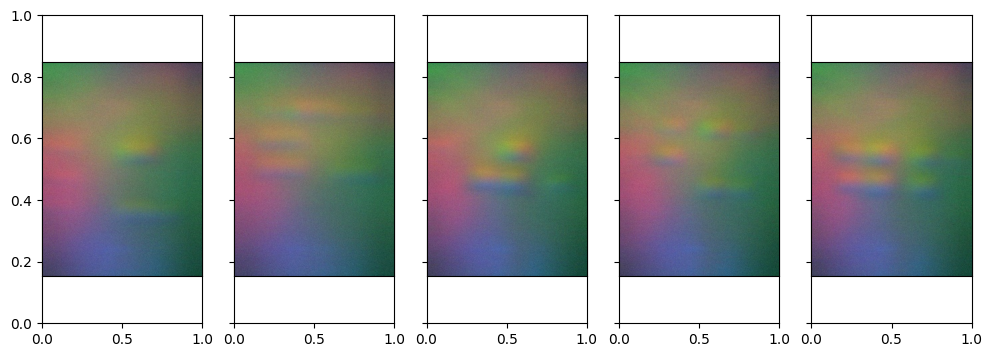

Shape output Images


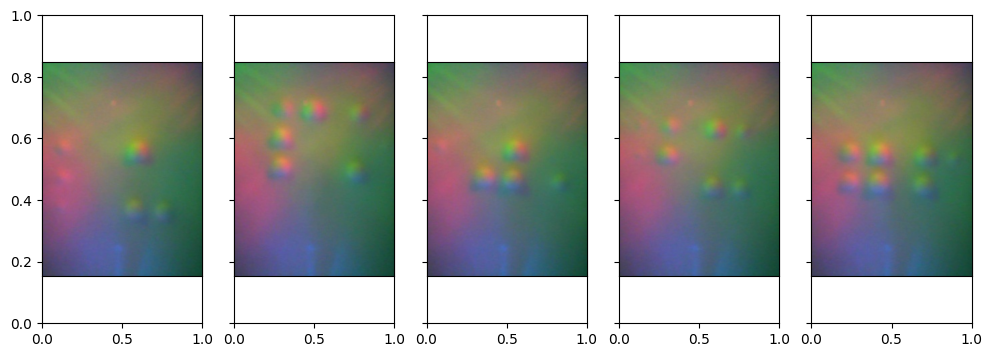

In [5]:
dataiter = iter(train_loader)
#For some reason this is needed
output = next(dataiter)
images = output['data'].numpy()
labels = output['label'].numpy()
#print(labels)
#Rather than this
#images, labels, _ = next(dataiter)
#images = images.numpy() # convert images to numpy for display


#Plot the images
print("Input Images (Sensor Data)")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(classes[labels[idx]])
plt.show()

#Output images
print("Shape output Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(labels[idx])
    #ax.set_title(classes[labels[idx]])
plt.show() 
    

In [6]:
print(images[0].shape)
print(labels[0].shape)
#print(images[0])

(3, 320, 240)
(3, 320, 240)


#  Conv autoencoder

In [13]:
class ConvAutoencoder(nn.Module):
    def __init__(self, layer_disp = False):
        super(ConvAutoencoder, self).__init__()
        self.layer_disp = layer_disp
        #Encoder
        #nn.Conv2(in_channels, out_channels, kernel_size, stride, padding)
        self.conv1 = nn.Conv2d(in_channels=3, 
                               out_channels=240,
                               kernel_size=2, 
                               stride = 1,
                               padding = 'same')
        self.conv2 = nn.Conv2d(in_channels=240, 
                               out_channels=480,
                               kernel_size=2, 
                               stride = 2,
                               padding = 0)
        
        self.conv3 = nn.Conv2d(in_channels=480, 
                               out_channels=480,
                               kernel_size=4, 
                               stride = 4,
                               padding = 0)
        
        
        
        self.pool = nn.MaxPool2d(2,2)
        
       
        #Decoder
        #nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
        self.t_conv1 = nn.ConvTranspose2d(in_channels=480, 
                               out_channels=240,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        self.t_conv2= nn.ConvTranspose2d(in_channels=240, 
                               out_channels=240,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        self.t_conv3= nn.ConvTranspose2d(in_channels=240, 
                               out_channels=120,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        
        self.t_conv4= nn.ConvTranspose2d(in_channels=120, 
                               out_channels=120,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        self.t_conv5= nn.ConvTranspose2d(in_channels=120, 
                               out_channels=60,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        '''self.t_conv6= nn.ConvTranspose2d(in_channels=32, 
                               out_channels=32,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)'''
       
        self.t_convout = nn.ConvTranspose2d(in_channels=60, 
                               out_channels=3,
                               kernel_size=2, 
                               stride = 2,
                               padding=0)
        #self.upsample = nn.functional.interpolate(scale_factor = 2)


    def forward(self, x):
        en_layer1 = F.relu(self.conv1(x))   
        en_layer1 = self.pool(en_layer1)
        en_layer2 = F.relu(self.conv2(en_layer1))
        en_layer2 = self.pool(en_layer2)
        en_layer3 = F.relu(self.conv3(en_layer2))
        en_layer3 = self.pool(en_layer3)

        #de_layer0 = F.relu(self.t_conv0(en_layer4)) 
        de_layer1 = F.relu(self.t_conv1(en_layer3))   
        #de_layer1 = nn.functional.interpolate(de_layer1,scale_factor = 2)
        de_layer2= F.relu(self.t_conv2(de_layer1)) 
        de_layer3= F.relu(self.t_conv3(de_layer2))
        de_layer4= F.relu(self.t_conv4(de_layer3))
        de_layer5= F.relu(self.t_conv5(de_layer4))
        #de_layer6= F.relu(self.t_conv6(de_layer5))
        
        #de_layerout = torch.sigmoid(self.t_conv3(de_layer2))
        de_layerout = F.relu(self.t_convout(de_layer5))
        #de_layerout = self.t_conv5(de_layer4)
        
        if self.layer_disp:
            print("input", x.shape)
            print("en_layer1",en_layer1.shape)
            #print("en_layer1a",en_layer1a.shape)
            print("en_layer2",en_layer2.shape)
            #print("en_layer2a",en_layer2a.shape)
            print("en_layer3",en_layer3.shape)
            #print("en_layer3a",en_layer3a.shape)
            #print("en_layer4",en_layer4.shape)
            #print("en_layer5",en_layer5.shape)
            
            #print("de_layer0",de_layer0.shape)
            print("de_layer1",de_layer1.shape)
            #print("de_layer1a",de_layer1a.shape)
            print("de_layer2",de_layer2.shape)
            print("de_layer3",de_layer3.shape)
            print("de_layer4",de_layer4.shape)
            print("de_layer5",de_layer5.shape)
            #print("de_layer6",de_layer6.shape)
            #print("de_layer2a",de_layer2a.shape)
            #print("de_layer3",de_layerou.shape)
            #print("de_layer3a",de_layer3a.shape)
            #print("de_layer4",de_layer4.shape)
            print("de_layerout",de_layerout.shape)
              
        return de_layerout

In [14]:
#Now to intialise the model and shit
model = ConvAutoencoder(layer_disp = False).to(device)
model = ConvAutoencoder(layer_disp = True).to(device)

#Defining the loss function between the input and the output
#criterion = nn.BCELoss()
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.5*1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma=0.5)

#This is just for testing and seeing the outputs of each convolutional layer
model(torch.empty(3, 320, 240).to(device))


input torch.Size([3, 320, 240])
en_layer1 torch.Size([128, 160, 120])
en_layer2 torch.Size([256, 40, 30])
en_layer3 torch.Size([256, 5, 3])
de_layer1 torch.Size([128, 10, 6])
de_layer2 torch.Size([128, 20, 12])
de_layer3 torch.Size([64, 40, 24])
de_layer4 torch.Size([64, 80, 48])
de_layer5 torch.Size([32, 160, 96])
de_layer4 torch.Size([64, 80, 48])
de_layerout torch.Size([3, 320, 192])


tensor([[[6.5699e+22, 0.0000e+00, 5.5719e+22,  ..., 0.0000e+00,
          2.2661e+21, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.6267e+23,
          0.0000e+00, 0.0000e+00],
         [4.2511e+22, 0.0000e+00, 2.2324e+22,  ..., 0.0000e+00,
          1.7292e+23, 0.0000e+00],
         ...,
         [0.0000e+00, 2.6720e+23, 2.6591e+23,  ..., 1.5483e+23,
          1.0992e+23, 0.0000e+00],
         [1.2696e+23, 1.2825e+23, 8.8765e+23,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.8743e+23, 2.0569e+23, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]],

        [[0.0000e+00, 1.8515e+23, 8.1644e+22,  ..., 5.0585e+23,
          0.0000e+00, 1.2836e+23],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2826e+23,
          0.0000e+00, 1.2217e+23],
         [0.0000e+00, 0.0000e+00, 6.6068e+22,  ..., 0.0000e+00,
          0.0000e+00, 2.5159e+23],
         ...,
         [0.0000e+00, 0.0000e+00, 4.1621e+23,  ..., 7.6507e+22,
          0.000

# Train the model

In [10]:
from livelossplot import PlotLosses

n_epochs = 10000 #Number of epochs

liveloss = PlotLosses()
logs = {}


for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_loader:
        #For some reason this is needed
        output = data
        #print(output)
        images = output['data']
        labels = output['label']
        #images, _ = data #Don't care about the labels
        images = images.to(device) 
        labels = labels.to(device) 
        optimizer.zero_grad()
        outputs = model(images)
        #outputs = model(labels) #to test if the autoencoder works
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    logs['loss'] = train_loss
    
    #print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    predictions = outputs
    predictions = predictions.detach().cpu().numpy()
    imshow(predictions[0])
    if not(epoch%50) or epoch ==0:
        plt.show()

    liveloss.update(logs)
    liveloss.send()
    

input torch.Size([64, 3, 320, 240])
en_layer1 torch.Size([64, 128, 160, 120])
en_layer2 torch.Size([64, 256, 40, 30])
en_layer3 torch.Size([64, 256, 5, 3])
de_layer1 torch.Size([64, 128, 10, 6])
de_layer2 torch.Size([64, 128, 20, 12])
de_layer3 torch.Size([64, 64, 40, 24])
de_layer4 torch.Size([64, 64, 80, 48])
de_layer5 torch.Size([64, 32, 160, 96])
de_layerout torch.Size([64, 3, 320, 192])


/home/parth/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 3, 320, 240])) that is different to the input size (torch.Size([64, 3, 320, 192])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (192) must match the size of tensor b (240) at non-singleton dimension 3

# Display the predictions

input torch.Size([64, 3, 128, 128])
en_layer1 torch.Size([64, 128, 64, 64])
en_layer2 torch.Size([64, 256, 16, 16])
en_layer3 torch.Size([64, 256, 2, 2])
de_layer1 torch.Size([64, 128, 4, 4])
de_layer2 torch.Size([64, 128, 8, 8])
de_layer3 torch.Size([64, 64, 16, 16])
de_layer4 torch.Size([64, 64, 32, 32])
de_layer5 torch.Size([64, 32, 64, 64])
de_layerout torch.Size([64, 3, 128, 128])
(64, 3, 128, 128)
torch.Size([64, 3, 128, 128])
Sensor Input


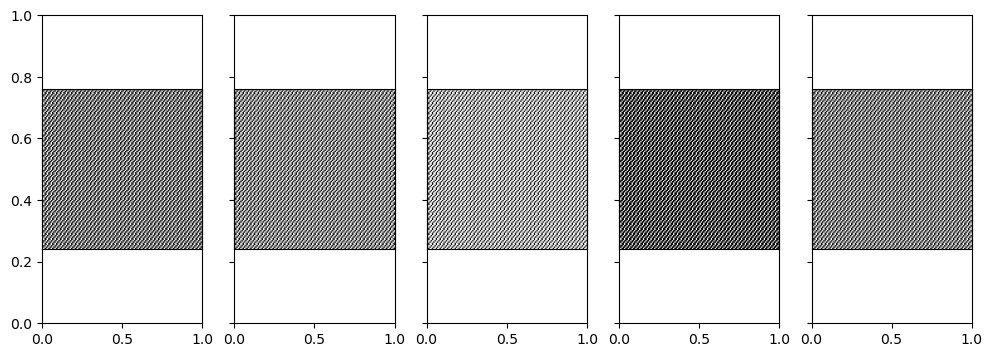

Real Shape Images


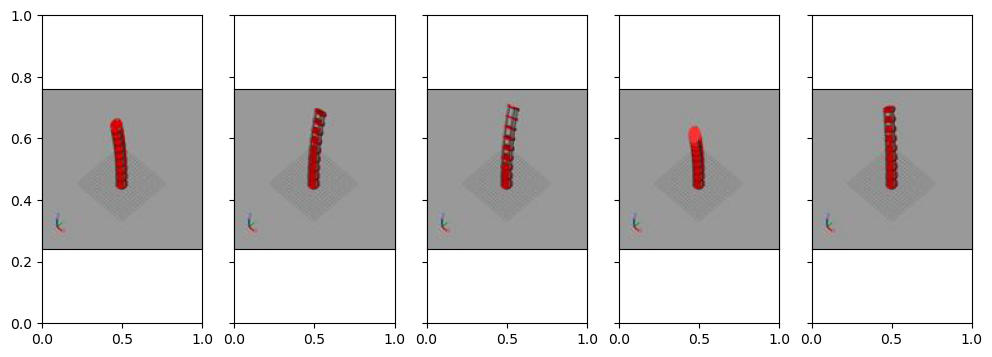

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Predicted Shape Images


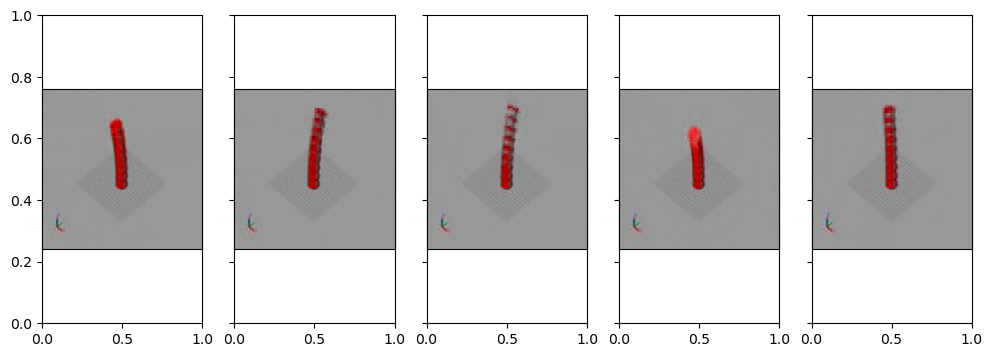

In [15]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=0, shuffle = True)
#Batch of test images
with torch.no_grad():
    dataiter = iter(train_loader)
    #images, labels = next(dataiter)
    output = next(dataiter)
    images = output['data'].to(device) #these are the inputs
    labels = output['label'].to(device)
    #labels = output['label'].numpy() #again labels aren't needed

    #Sample outputs
    #predictions = model(labels) #test just the atoencoder ibit
    predictions = model(images) #output of the network
    images = images.detach().cpu().numpy() #convert the images back to numpy arrays
    labels = labels.detach().cpu().numpy() #convert the images back to numpy arrays

    #convert back to appropriate numpy array and shit
    print(images.shape)
    print(predictions.shape)
    predictions = predictions.detach().cpu().numpy()
    #predictions = predictions.view(batch_size, 3, 32, 32)


    #Original Images
    print("Sensor Input")
    fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
    for idx in np.arange(5):
        ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        #ax.set_title(classes[labels[idx]])
    plt.show()
    
    #Original Images
    print("Real Shape Images")
    fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
    for idx in np.arange(5):
        ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
        imshow(labels[idx])
        #ax.set_title(classes[labels[idx]])
    plt.show()

    #Reconstructed Images
    print('Reconstructed Predicted Shape Images')
    fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
    for idx in np.arange(5):
        ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
        imshow(predictions[idx])
        #ax.set_title(classes[labels[idx]])
    plt.show() 

In [ ]:
'''TEST WITH DATA FROM THE LARGER SET???'''